In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace, sobel
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2

In [2]:
def gaussian_highpass(image, sigma=1.5):
    """Apply Gaussian high-pass filter to an image."""
    lowpass = gaussian_filter(image, sigma=sigma)
    highpass = image - lowpass
    return highpass

def self_quotient_image(image, sigma=1.5):
    """Compute Self-Quotient Image."""
    highpass = gaussian_highpass(image, sigma=sigma)
    local_mean = gaussian_filter(highpass, sigma=sigma)
    quotient_image = np.divide(highpass, local_mean + 1e-5)  # Avoid division by zero
    return quotient_image

def laplacian_of_gaussian(image, sigma=3.0):
    """Apply Laplacian-of-Gaussian filter to an image."""
    return laplace(gaussian_filter(image, sigma=sigma))

def gradient_filters(image):
    """Compute directional gradients of an image (x and y)."""
    grad_x = sobel(image, axis=0)
    grad_y = sobel(image, axis=1)
    return grad_x, grad_y

In [3]:
def cosine_similarity(image1, image2):
    """Calculate the cosine similarity between two images."""
    return 1 - cosine(image1.flatten(), image2.flatten())

def mutual_subspace_method(images1, images2, n_components=6):
    """Calculate MSM similarity between two sets of images."""
    pca = PCA(n_components=n_components)
    subspace1 = pca.fit_transform(images1)
    subspace2 = pca.fit_transform(images2)
    
    u, _, vh = np.linalg.svd(subspace1.T @ subspace2)
    correlations = np.diag(u.T @ vh)
    return np.mean(correlations[:3])

In [4]:
def adaptive_similarity(query_image, gallery_images, filter_function, similarity_function):
    """Calculate adaptive similarity based on confusion margin."""
    unprocessed_similarities = [similarity_function(query_image, gallery) for gallery in gallery_images]
    filtered_similarities = [similarity_function(filter_function(query_image), filter_function(gallery)) for gallery in gallery_images]
    
    # Get confusion margin
    top_similarities = sorted(unprocessed_similarities, reverse=True)[:2]
    confusion_margin = top_similarities[0] - top_similarities[1]
    
    # Weight based on confusion margin
    alpha = 1 / (1 + np.exp(-confusion_margin * 10))  # Sigmoid function as weighting function
    combined_similarity = [alpha * u + (1 - alpha) * f for u, f in zip(unprocessed_similarities, filtered_similarities)]
    
    return np.max(combined_similarity)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D


def plot_joint_density(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(10, 6)):
    """
    Plot the joint density p(alpha, mu) as a 2D landscape.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density for the heatmap
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.imshow(
        expanded_density,
        aspect="auto",
        extent=[0, 1, 0, 1],
        origin="lower",
        cmap="viridis",
        norm=Normalize(vmin=0, vmax=np.max(expanded_density))
    )
    
    plt.colorbar(label="Density")
    plt.title(f"Joint Density Landscape at Iteration {iteration}")
    plt.xlabel("Alpha (Weight for Raw Similarity)")
    plt.ylabel("Confusion Margin")
    plt.savefig(f"joint_density_{iteration}.png")
    plt.show()


def plot_joint_density_3d(alpha_grid, density, iteration, confusion_margin_bins=50, figsize=(12, 8)):
    """
    Plot the joint density p(alpha, mu) as a 3D surface.

    Parameters:
    - alpha_grid (np.ndarray): The discrete alpha values.
    - density (np.ndarray): Current density values for each alpha.
    - iteration (int): Current iteration number (for title annotation).
    - confusion_margin_bins (int): Number of bins for confusion margin axis.
    - figsize (tuple): Figure size for the plot.

    Returns:
    - None (shows the plot).
    """
    # Normalize density
    normalized_density = density / np.sum(density, axis=0, keepdims=True)
    
    # Generate confusion margin axis
    confusion_margin = np.linspace(0, 1, confusion_margin_bins)
    
    # Expand density to match the dimensions for plotting
    expanded_density = np.tile(normalized_density, (confusion_margin_bins, 1))
    
    # Create meshgrid for plotting
    alpha, margin = np.meshgrid(alpha_grid, confusion_margin)
    
    # 3D Plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(alpha, margin, expanded_density, cmap='viridis', edgecolor='none')
    
    # Labels and title
    ax.set_title(f"Joint Density Landscape at Iteration {iteration}")
    ax.set_xlabel("Alpha (Weight for Raw Similarity)")
    ax.set_ylabel("Confusion Margin")
    ax.set_zlabel("Density")
    plt.show()


In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def plot_density_over_epochs(alpha_grid, mu_grid, density_epochs, epoch_intervals):
    """
    Plot the joint probability density of α and μ over epochs in 3D.

    Parameters:
    -----------
    alpha_grid : array
        Grid of α values.
    mu_grid : array
        Grid of μ values.
    density_epochs : list of arrays
        List of density matrices for each epoch interval.
    epoch_intervals : list of ints
        Epoch intervals corresponding to the densities.
    """
    alpha, mu = np.meshgrid(alpha_grid, mu_grid)

    for epoch_idx, epoch_density in enumerate(density_epochs):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Transpose the density for correct plotting
        ax.plot_surface(alpha, mu, epoch_density.T, cmap="viridis", edgecolor='k', alpha=0.8)

        # Labels and title
        ax.set_xlabel('Alpha (α)')
        ax.set_ylabel('Mu (μ)')
        ax.set_zlabel('Density')
        ax.set_title(f'Joint Probability Density at Epoch {epoch_intervals[epoch_idx]}')
        
        # Add a color bar
        mappable = plt.cm.ScalarMappable(cmap="viridis")
        mappable.set_array(epoch_density)
        fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='Density')

        plt.show()


In [20]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


def estimate_joint_probability(training_data, filter_function, similarity_function, alpha_grid_size, mu_grid_size, n_iter=500, plot_intervals=10):
    """
    Train the joint probability density p(α, μ) and visualize its evolution over epochs.
    
    Parameters:
    -----------
    training_data : list or array
        List of training images.
    filter_function : callable
        Function to filter/process images.
    similarity_function : callable
        Function to compute similarity between two images.
    alpha_grid_size : int
        Number of points in α grid.
    mu_grid_size : int
        Number of points in μ grid.
    n_iter : int
        Number of iterations for estimation.
    plot_intervals : int
        Interval (in iterations) to record and plot density progress.
    
    Returns:
    --------
    alpha_grid : array
        Grid of α values.
    mu_grid : array
        Grid of μ values.
    density : array
        Final estimated joint probability density.
    """
    # Initialize α and μ grids and density
    alpha_grid = np.linspace(0, 1, alpha_grid_size)
    mu_grid = np.linspace(-1, 1, mu_grid_size)
    density = np.zeros((alpha_grid_size, mu_grid_size))
    
    # Track densities for plotting
    density_epochs = []
    epoch_intervals = []
    
    # Training loop
    for iteration in range(n_iter):
        # Randomly select a query image
        query_idx = np.random.choice(len(training_data))
        query_image = training_data[query_idx]

        # Compute similarities
        all_unprocessed_similarities = []
        all_filtered_similarities = []
        
        for i in range(len(training_data)):
            if i != query_idx:
                unproc_sim = similarity_function(query_image, training_data[i])
                filt_sim = similarity_function(
                    filter_function(query_image),
                    filter_function(training_data[i])
                )
                all_unprocessed_similarities.append(unproc_sim)
                all_filtered_similarities.append(filt_sim)
        
        # Compute confusion margin (μ)
        top_similarities = sorted(all_unprocessed_similarities, reverse=True)[:2]
        if len(top_similarities) < 2:
            continue  # Skip if there are not enough similarities
        
        mu = top_similarities[0] - top_similarities[1]
        mu_idx = np.argmin(np.abs(mu_grid - mu))
        
        # Compute performance for each α
        for alpha_idx, alpha in enumerate(alpha_grid):
            combined_similarities = [
                alpha * u + (1 - alpha) * f
                for u, f in zip(all_unprocessed_similarities, all_filtered_similarities)
            ]
            if combined_similarities:
                max_combined = max(combined_similarities)
                performance = combined_similarities.count(max_combined)  # Example metric
                density[alpha_idx, mu_idx] += performance
        
        # Record densities at specified intervals
        if (iteration + 1) % plot_intervals == 0:
            density_smoothed = gaussian_filter(density, sigma=0.05 * max(alpha_grid_size, mu_grid_size))
            density_epochs.append(density_smoothed.copy())
            epoch_intervals.append(iteration + 1)
    
    # Normalize final density
    density = gaussian_filter(density, sigma=0.05 * max(alpha_grid_size, mu_grid_size))
    density /= np.sum(density) if np.sum(density) > 0 else 1.0
    
    # Add final density to epochs for visualization
    density_epochs.append(density)
    epoch_intervals.append(n_iter)
    
    # Plot the density evolution
    plot_density_over_epochs(alpha_grid, mu_grid, density_epochs, epoch_intervals)
    
    return alpha_grid, mu_grid, density


In [7]:
def match_faces(query_image, gallery_images, filter_function, similarity_function, alpha_grid, mu_grid, density):
    """
    Match query face to gallery images using adaptive weighting based on joint probability density.
    
    Parameters:
    -----------
    query_image : array-like
        The query face image to match
    gallery_images : list
        List of gallery face images to match against
    filter_function : callable
        Function to filter/process images
    similarity_function : callable
        Function to compute similarity between two images
    alpha_grid : array
        Grid of alpha values from joint probability estimation
    mu_grid : array
        Grid of mu values from joint probability estimation
    density : array
        Joint probability density matrix (alpha × mu)
    
    Returns:
    --------
    tuple
        (best_matching_image, similarity_score, optimal_alpha)
    """
    if not gallery_images:
        raise ValueError("Gallery images list is empty")
        
    # Pre-compute filtered query image
    filtered_query = filter_function(query_image)
    
    # Initialize tracking variables
    best_similarity = -np.inf
    best_match = None
    best_alpha = None
    
    # Pre-compute all similarities and store them
    gallery_similarities = []
    
    for gallery_image in gallery_images:
        # Compute both similarity types
        unprocessed_sim = similarity_function(query_image, gallery_image)
        filtered_sim = similarity_function(filtered_query, filter_function(gallery_image))
        
        gallery_similarities.append((unprocessed_sim, filtered_sim))
    
    # Sort similarities to compute confusion margin
    unprocessed_sims = [s[0] for s in gallery_similarities]
    top_two_sims = sorted(unprocessed_sims, reverse=True)[:2]
    
    if len(top_two_sims) >= 2:
        # Compute confusion margin (mu)
        mu = top_two_sims[0] - top_two_sims[1]
        
        # Find closest mu index in mu_grid
        mu_idx = np.argmin(np.abs(mu_grid - mu))
        
        # Get the density slice for this mu
        alpha_weights = density[:, mu_idx]
        
        # Find optimal alpha (weight with maximum density for this mu)
        optimal_alpha_idx = np.argmax(alpha_weights)
        optimal_alpha = alpha_grid[optimal_alpha_idx]
        
        # Compare all gallery images using optimal alpha
        for i, (unprocessed_sim, filtered_sim) in enumerate(gallery_similarities):
            # Compute weighted combination
            combined_similarity = (optimal_alpha * unprocessed_sim + 
                                (1 - optimal_alpha) * filtered_sim)
            
            if combined_similarity > best_similarity:
                best_similarity = combined_similarity
                best_match = gallery_images[i]
                best_alpha = optimal_alpha
    else:
        # Fallback if we don't have enough images for confusion margin
        optimal_alpha = 0.5  # Use equal weighting as fallback
        for i, (unprocessed_sim, filtered_sim) in enumerate(gallery_similarities):
            combined_similarity = (optimal_alpha * unprocessed_sim + 
                                (1 - optimal_alpha) * filtered_sim)
            
            if combined_similarity > best_similarity:
                best_similarity = combined_similarity
                best_match = gallery_images[i]
                best_alpha = optimal_alpha
    
    return best_match, best_similarity, best_alpha

# Helper function to visualize the matching results
def visualize_match_results(query_image, best_match, similarity_score, optimal_alpha):
    """
    Visualize the matching results including the query image, best match, and metrics.
    Can be implemented based on your visualization needs.
    """
    print(f"Matching Results:")
    print(f"Similarity Score: {similarity_score:.4f}")
    print(f"Optimal Alpha: {optimal_alpha:.4f}")
    # Add visualization code here based on your image display requirements
    return

In [8]:
def load_image(filename):
    """Load an image from file."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def preview_image(image):
    """Preview an image using matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

Query image:


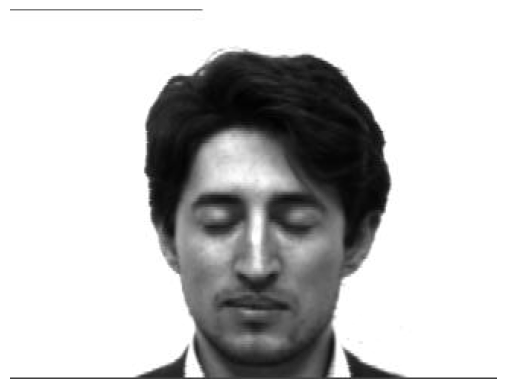

In [9]:
query_image = load_image('subject03.sleepy_frame_1.jpg')
print('Query image:')
preview_image(query_image)

In [10]:
# extract all file paths ending with jpg
import os
import glob
gallery_images = []
for file in glob.glob("data_new/*.jpg"):
    gallery_images.append(load_image(file))

# preview the first 3 gallery images
print(f"Loaded {len(gallery_images)} gallery images.")
# print('Gallery images:')
# for i in range(3):
#     preview_image(gallery_images[i])

Loaded 179 gallery images.


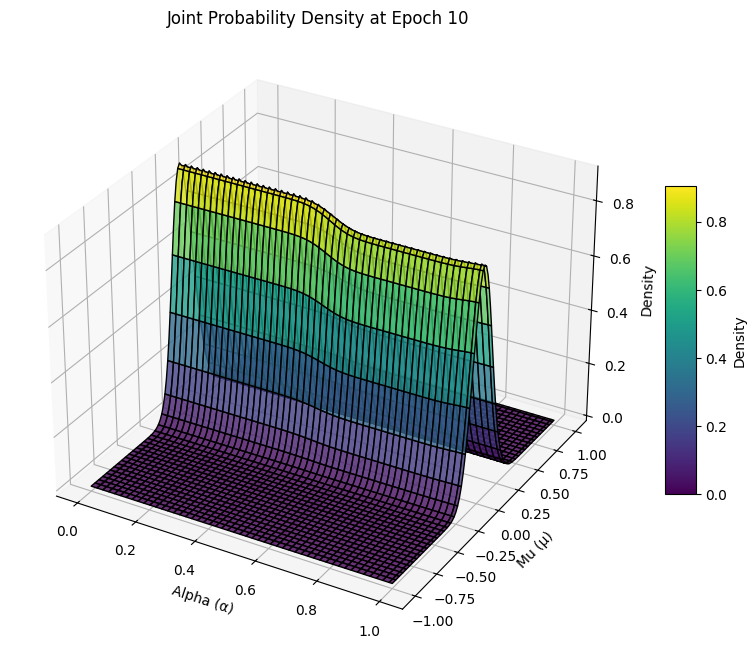

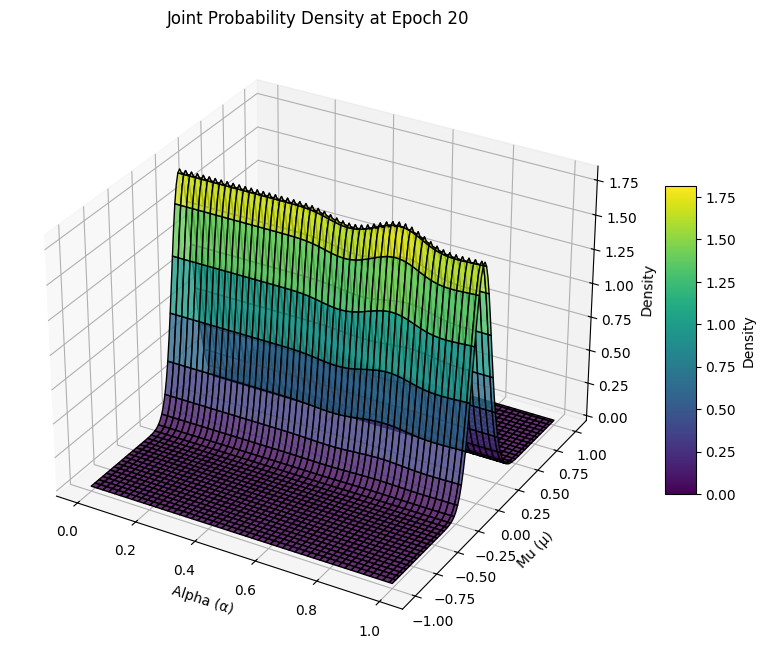

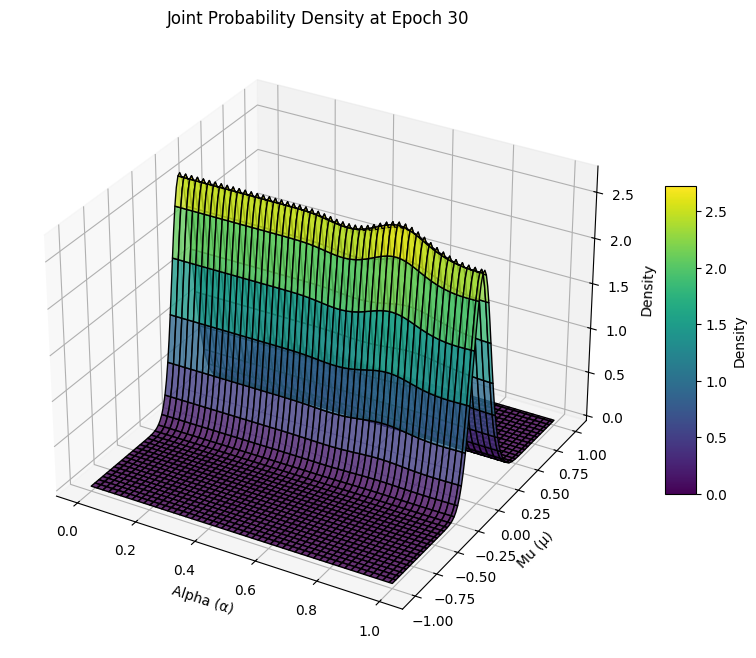

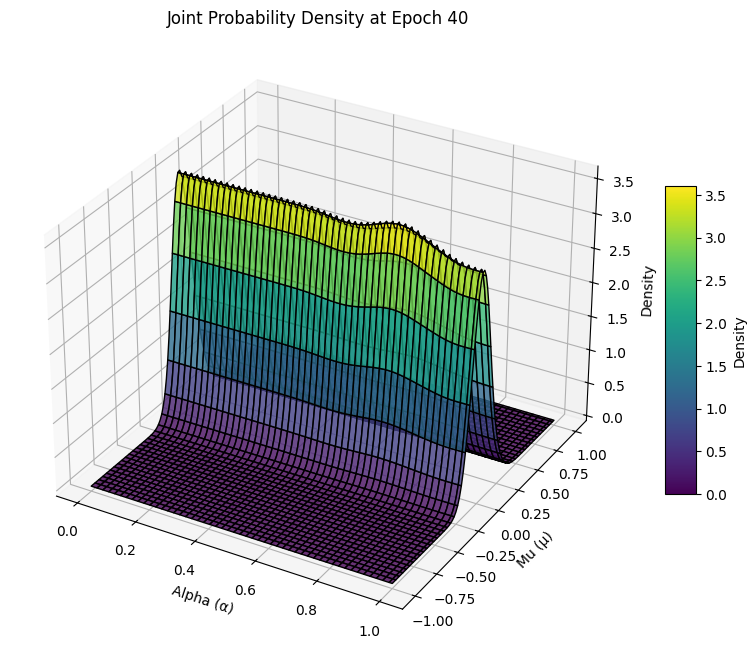

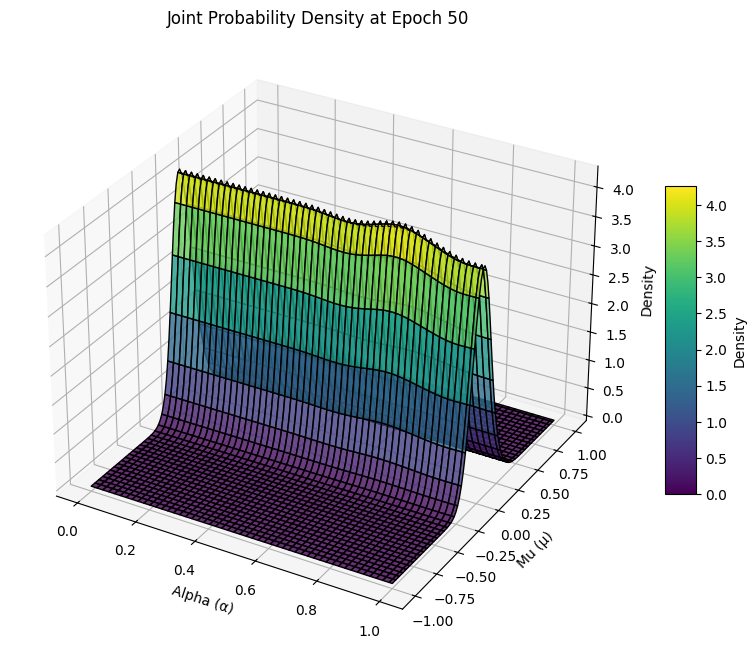

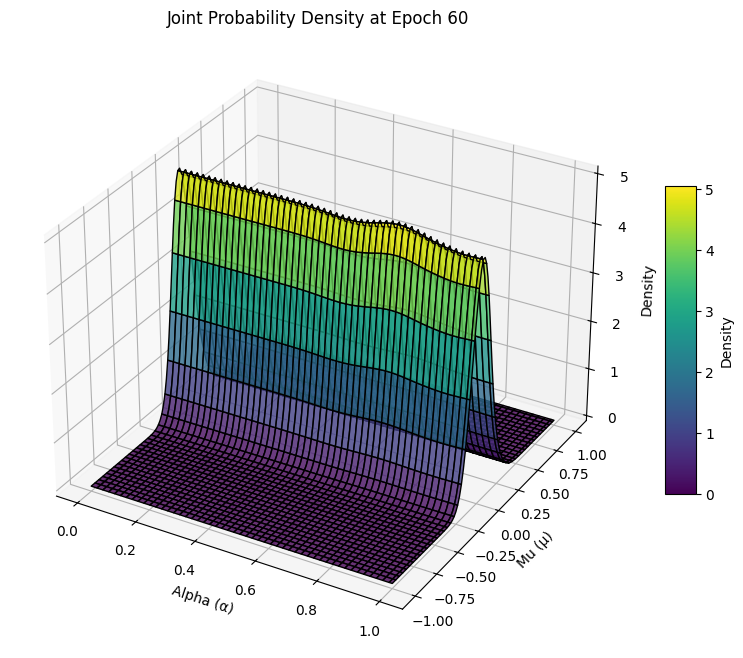

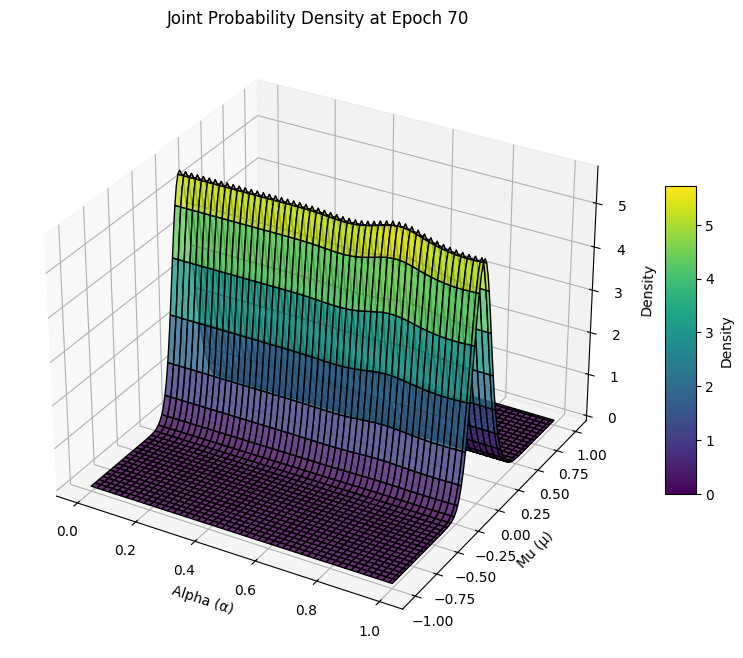

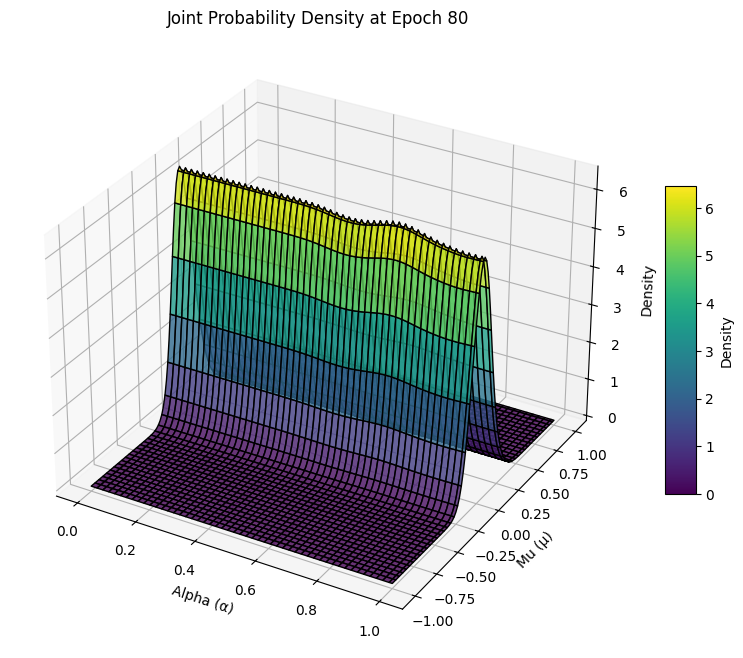

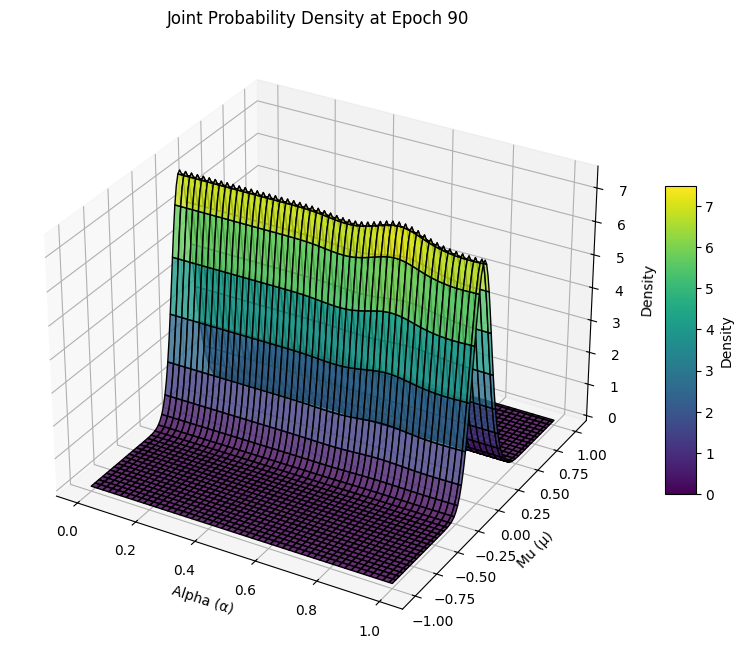

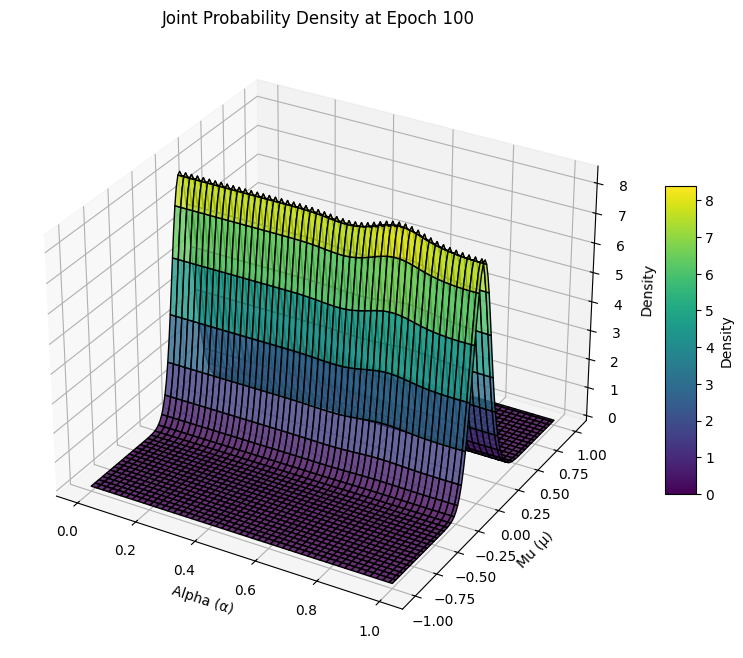

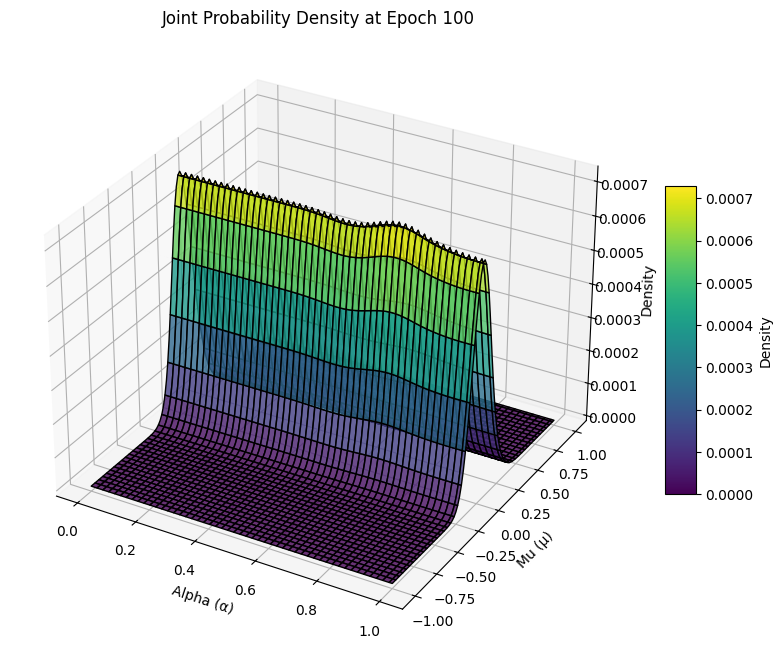

In [21]:
# Example usage with dummy data (to be replaced with actual images)
# query_image = np.random.rand(50, 50)  # Replace with actual image
# gallery_images = [np.random.rand(50, 50) for _ in range(10)]  # Replace with gallery images

ITERRATIONS = 100

alpha_grid,mu_grid, density = estimate_joint_probability(gallery_images, self_quotient_image, cosine_similarity, alpha_grid_size=100,mu_grid_size=100, n_iter=ITERRATIONS)
best_match, similarity_score,alpha = match_faces(query_image, gallery_images, self_quotient_image, cosine_similarity, alpha_grid,mu_grid, density)




Query image:


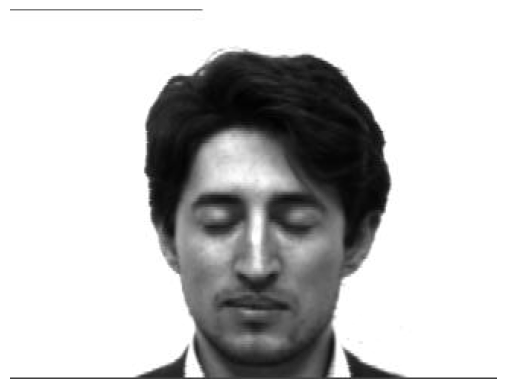

Best match:


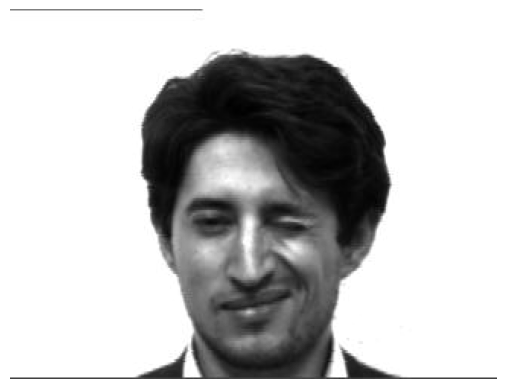

Best Match Similarity Score: 0.8453363003010791


In [ ]:
print('Query image:')
preview_image(query_image)

print('Best match:')
preview_image(best_match)

print("Best Match Similarity Score:", similarity_score)
